# Open Street Map SF Study
<hr><i>By: Praneetha Potiny</i>


<h2> Code Functionality</h2><hr>
<p>I have three functions in audit.py that I use to audit the open street map data. In this project I only focus on the key-value pairs for the nodes tags. Each function deals with one value at a time. I dealt with the keys that I thought were the most problematic which were:</p>
<br>
<li>Phone Numbers</li>
<li>Street Address</li>
<li>Source</li>

<p> I also have other functions I use to query the database for statistics </p>
<p>All database querying was done using sqlite3</p>

In [1]:
import sqlite3
db = sqlite3.connect("SanFranciscoOSM.db")
cur = db.cursor()

<h2>Problematic Areas</h2><hr>
<h3>Phone Numbers</h3>
<br>
I came across a variety of formats for phone numbers. The first thing I wanted to do was put them all in the same format. Some phone numbers had letters so I included all alpha-numeric characters and placed them in the form of '+1-###-###-####'. I noticed that some numbers were missing digits or contained something other than a phone number (like a website). These were returned as None.

Some formats that I saw were:
<li>123-456-7890 (missing the country code)</li>
<li>1234567890 (missing dashes)</li>
<li>123-456-789 (missing digits)</li>

Except for the last number, all of the above numbers would be formatted as '+1-123-456-7890'. The last number would return None.

<h3>Street Addresses</h3>
<br>
When auditing street addresses, I decided to focus on abbreviations, variations in capitilization, and punctuation. I did not translate cardinal directions, because there were streets that actually contained the single letter 'E' but did not translate to East. I knew this because there were other streets that started with single letters (e.g. - 'D Street').

Here are some examples of how they will be converted:
<li>E Street -- (E Street)</li>
<li>Upton St. -- ('Upton Street')</li>
<li>foothill blvd -- ('Foothill Boulevard')</li>
<li>Woodside Road, Suite 100 -- ('Woodside Road')</li>
<li>A st. & N blvd -- (('A Street', 'N Boulevard'))</li>

I removed numbers in the beginning and ending of street names, as well as the word 'suite' or 'ste'. I realized that most people did not put in their exact addresses. I reasoned that having generalized street names would make them easier to analyze as groups.
Also, if there were two addresses present, I would return them as a tuple.

In [2]:
good_street_names = {'rd': 'Road',
                     'plz': 'Plaza',
                     'blvd': 'Boulevard',
                     'ave': 'Avenue',
                     'st': 'Street',
                     'hwy': 'Highway',
                     'ctr': 'Center',
                     'dr': 'Drive'}

<h3>Source</h3>
<br>
The sources for each node refer to the source of information for a specific node. Many of the sources were very specific. In order to be able to group each source into a category, I glanced through the unique sources and came up with a list of the most common sources by their most simplistic names. I also did the same with websites, by making it less specific.

All sources that were not converted stay exactly as they are.

Here are some examples of how they will be converted:
<li>Field Observation -- ('observation')</li>
<li>Google; Yahoo -- (('google', 'yahoo')) </li>
<li>NPS map -- ('map')</li>
<li>http://www.dot.ca.gov/ ... /101.pdf -- ('http://www.dot/ca/gov/')</li>
<li>Street View -- ('Street View')</li> 

<i>Note</i>: The '...' in the 4th bullet was used for convenience and is not actually what is written


In [3]:
common_sources = ['bing', 'yahoo', 'google', 'survey', 'map', 'observation',
                  'knowledge', 'gps', 'yelp', 'website', 'gtfs', 'usgs']

common_webs = ['dot.ca.gov', 'yelp.com/biz']

<h2>Statistics</h2>

### File Size

<i>San Francisco OSM -- 400.722 MB</i>

### Number of Nodes

In [4]:
cur.execute("SELECT COUNT(*) FROM nodes")
for c in cur: print c[0]

4533476


### Number of Ways

In [5]:
cur.execute("SELECT COUNT(*) FROM ways")
for c in cur: print c[0]

524685


### Top 10 keys for Nodes

In [6]:
cur.execute("""
            SELECT k, COUNT(*) FROM nodes_tags 
            GROUP BY k 
            ORDER BY COUNT(*) DESC 
            LIMIT 10
                    """)
for c in cur: print c[1], '|', c[0]

24660 | addr:housenumber
23279 | highway
22115 | addr:street
18205 | addr:city
16964 | name
12994 | created_by
12634 | amenity
7807 | source
7503 | addr:postcode
6386 | addr:state


### Top 10 keys for Ways

In [7]:
cur.execute("""
            SELECT k, COUNT(*) FROM ways_tags 
            GROUP BY k 
            ORDER BY COUNT(*) DESC 
            LIMIT 10
                    """)

for c in cur: print c[1], '|', c[0]

397148 | building
95714 | highway
68736 | name
54283 | source
52702 | tiger:county
51493 | tiger:cfcc
49029 | tiger:name_base
46095 | tiger:name_type
44556 | height
40008 | tiger:zip_left


### Number of unique keys

In [8]:
cur.execute("""
            SELECT COUNT(*) FROM
            (SELECT DISTINCT(k) FROM
            (SELECT k from nodes_tags
            UNION ALL
            SELECT k from ways_tags))
                            """)
for c in cur: print c[0]

1379


### Top 10 Cities

In [9]:
# This gets the count for every node and way that contains a key for a city.
cur.execute("""
            SELECT COUNT(*) FROM 
            (SELECT v from nodes_tags WHERE k='addr:city' 
            UNION ALL
            SELECT v from ways_tags WHERE k='addr:city')
                                                        """)

v_count = [c[0] for c in cur]


# This gets the top ten cities for both nodes and ways and their count
cur.execute("""
            SELECT v, COUNT(*) as count FROM
            (SELECT v from nodes_tags WHERE k='addr:city' 
            UNION ALL
            SELECT v from ways_tags WHERE k='addr:city')
            GROUP BY v
            ORDER BY count DESC
            LIMIT 10
                                                        """)

# Here, I get a percentage by dividing the city's count with v_count and multiplying by 100. 
# The result is formatted to 2 decimal places

for c in cur:
    print "{0:.2f}".format((c[1]*100.0)/v_count[0])+'%', "|", c[0]

41.44% | Redwood City
30.28% | San Francisco
9.90% | Berkeley
6.71% | Piedmont
2.89% | Palo Alto
2.38% | Richmond
2.36% | Oakland
0.46% | Union City
0.39% | Albany
0.35% | Burlingame


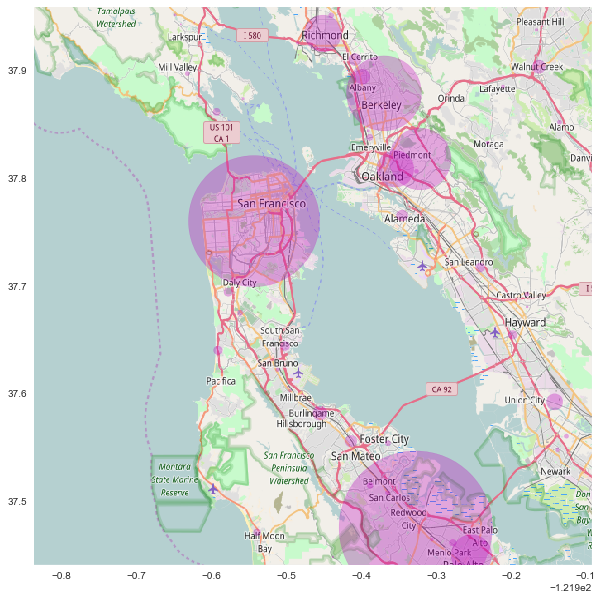

In [10]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Average longitude and latitude for each city
lonlat_df = pd.read_sql("""SELECT AVG(lon) as lon, AVG(lat) as lat, v as city FROM
            (SELECT lon, lat, k, v FROM nodes_tags
            INNER JOIN nodes
            ON nodes.id = nodes_tags.id)
            WHERE k='addr:city'
            GROUP BY v""", db)

# Count for each city
city_count = pd.read_sql("""SELECT COUNT(*) as count, v as city FROM
                            (SELECT v FROM nodes_tags WHERE k='addr:city'
                            UNION ALL
                            SELECT v FROM ways_tags WHERE k='addr:city')
                            GROUP BY city""", db)

# Merge the datasets above by city
city_count = city_count.merge(lonlat_df, how='inner', on='city')

%matplotlib inline


f = plt.figure(figsize = (10,10)) 
sf_img = mpimg.imread('sfmap.png')  # Load the map image

# Create a scatterplot where circle size reflects the number of records per city
ax2 = f.add_subplot(111)
ax2.scatter(city_count['lon'], city_count['lat'], city_count['count'], color='m', alpha=0.3)

# Load the map with the longitude and latitude as the x and y axes respectively
ax = f.add_subplot(111)
ax.imshow(sf_img, interpolation='none', aspect = 'auto', extent=[-122.7369, -121.9920, 37.4420, 37.9600])
ax.grid(False)

plt.show()

### <i>Redwood City?</i>

It seems like this map should more appropriately be named Redwood City, San Francisco, and some others. What is most astonishing about this, is that Redwood City is pretty far from San Francisco, yet 41.44% of the data is related to Redwood City. Perhaps users in this city filled out most of this region of the map.

<h2>Additional Statistics</h2>
<hr>
### Top 10 fast food cuisines for nodes

In [11]:
cur.execute("""SELECT v, COUNT(*) FROM nodes_tags WHERE id IN
                (SELECT id FROM nodes_tags
                WHERE k='amenity' AND v='fast_food')
                AND k='cuisine'
                GROUP BY v
                ORDER BY COUNT(*) DESC
                LIMIT 10""")

for c in cur:
    print c[1], "|", c[0]

68 | burger
60 | sandwich
39 | mexican
39 | pizza
16 | chicken
14 | ice_cream
7 | bagel
7 | chinese
6 | american
4 | juice


### The 3 most popular kinds of shops

In [12]:
cur.execute("""
            SELECT v, COUNT(*) FROM nodes_tags 
            WHERE k='shop'
            GROUP BY v 
            ORDER BY COUNT(*) 
            DESC LIMIT 3
                        """)

for c in cur:
        print c[1], '|', c[0]

331 | convenience
326 | clothes
309 | hairdresser


### Biggest Coffee Shop Chain

In [13]:
cur.execute("""SELECT v, COUNT(*) FROM nodes_tags WHERE id IN
                (SELECT id FROM nodes_tags
                WHERE k='amenity' AND v='cafe')
                AND k='name'
                GROUP BY v
                ORDER BY COUNT(*) DESC
                LIMIT 1""")

for c in cur:
    print c[1], '|', c[0]

115 | Starbucks


<h2>Suggestions</h2>
<hr>
#### What I saw:
<li> 199 shops with the value: 'yes' </li>
<li> Shops with a 'yes' were the 5th most popular 'shop type' </li>
<li> Redwood City and San Francisco made up 71.72% of the data </li>

As I was looking through the data, I noted that there were a lot of shops that contained 'yes' as a value instead of the shop type.
One way to prevent this would be to ask users specifically for the shop type and to give examples.

Redwood City and San Francisco are far away from each other if you compare them on this map region. Since the map contains that much data, we're going to need a lot more data on the other cities between them. This map includes the 'East Bay', 'West Bay', and some of the 'North Bay' region. If this is noted in the map, then we may have more edits on the other cities. However, people may be more inclined to not take part if they see that the region is this big.

When I was cleaning the sources, I noticed that many got their sources from yelp or government data. Perhaps, if we focused on getting similar sources, then there would be less variation between values.

<h2>Conclusion</h2>
<hr>
The area is fairly large, so it wasn't surprising to see a variety of cities on the map. Although I was surprised to see that Redwood City had the largest number of records. Overall, I believe cleaning the dataset did make it easier to analyze the phone numbers, streets, and sources, because we can group more of the values together. I think getting data from similar sources and re-visiting those sources after a certain period of time will help make for a more accurate data-set.